# Implementing word embeding from scratch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/NLP/

/content/drive/My Drive/NLP


In [4]:
with open('alice.txt', 'r') as f:
    filedata = f.readlines()

In [1]:
# print(filedata)

# Importing libraries

In [5]:
import numpy as np
import keras.backend as K
import tensorflow as tf
import operator
from tensorflow import keras

from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import sequence
from sklearn.metrics.pairwise import cosine_distances

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
import pandas as pd

**Data pre-processing**

In [6]:
filedata = [sentence for sentence in filedata if sentence.count(" ") >= 2]

# Remove punctuation in text and fit tokenizer on entire corpus
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n'+"'")

The tokenizer will filter the punctuation and other irrelevent data and will assign each word in the text to unique integer

In [7]:
# This will first filter the text and then tokenize the words in the text
# Assign an index based on the frequency (words with the same frequency can be ordered by their first appearance):
#{'a': 1, 'quick': 2, 'brown': 3, 'fox': 4, 'jump': 5, 'the': 6, 'lady': 7}

tokenizer.fit_on_texts(filedata)

# this will retreive the word_index formed above
word_index = tokenizer.word_index

vocab_size = len(word_index) + 1
vocab_unique=len(word_index)+1

# This will assign each word of the sentence with the word index assign with it
sequences = tokenizer.texts_to_sequences(filedata)

Checking some sample data points

In [10]:
import random

print("Tokenized sequences:", sequences[:2])
samplesize=4
indexsample=random.sample(list(word_index.items()), samplesize)

dictindexsample=dict(indexsample)
print("Word index:", dictindexsample)

Tokenized sequences: [[305, 7, 38, 1, 92, 595], [11, 13, 253, 3, 106, 30, 470, 8, 342, 76, 16, 379, 20, 1]]
Word index: {'everybody': 446, 'reasonable': 2427, 'ye': 1793, 'each': 453}


## Applying the skipgram model which will find the context words from the target word

In [ ]:
skipgramsoftxt=[skipgrams(sequence, vocab_size, window_size=2)for sequence in sequences]

In [ ]:
# Checking some samples
skipgramsoftxt[0]

([[1, 412],
  [595, 1],
  [1, 92],
  [1, 2152],
  [92, 500],
  [1, 2278],
  [92, 595],
  [38, 528],
  [38, 7],
  [38, 92],
  [92, 1331],
  [305, 1595],
  [92, 434],
  [92, 1],
  [305, 2148],
  [305, 38],
  [1, 7],
  [595, 201],
  [7, 38],
  [1, 595],
  [1, 1418],
  [7, 1104],
  [7, 305],
  [305, 7],
  [7, 2286],
  [92, 38],
  [38, 26],
  [7, 1],
  [38, 1],
  [38, 305],
  [595, 92],
  [1, 38],
  [38, 710],
  [7, 1472],
  [595, 160],
  [38, 686]],
 [0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0])

The skipgrams produces pairs and labels.

Pair: These are pair derived from the sequences given to it and fixed window size

Labels: This tells wether the pair is from context window or not because we pick words from context window and also randomly from dictionary and label them as zero meaning negative sampling

In [ ]:
pairs = []

for sublist in skipgramsoftxt:
    pairs_list = sublist[0]

    for pair in pairs_list:
        pairs.append(pair)

labels = []

for sublist in skipgramsoftxt:
    labels_list = sublist[1]

    for label in labels_list:
        labels.append(label)

# View some sample pairs and labels
print("Sample pairs:", pairs[:5])
print("Sample labels:", labels[:5])

Sample pairs: [[1, 412], [595, 1], [1, 92], [1, 2152], [92, 500]]
Sample labels: [0, 1, 1, 0, 0]




---

# Training the model

In neural networks for natural language processing (NLP), an embedding layer is typically used as the first layer to convert input text (represented as integers or categorical values) into dense vectors of fixed size, called embeddings.

In [ ]:
#dimension of embeding
embedding_dim = 50

#model
model=Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,output_dim=embedding_dim, input_length=1))

The Reshape layer in Keras is used to reshape the tensor output from the previous layer into a desired shape.

The Dense layer in Keras is a fully connected neural network layer where every input neuron is connected to every output neuron.

activation='softmax' specifies the activation function for the output layer. In Word2Vec implementations, softmax activation is used to compute probabilities of each word in the vocabulary being the center word (for skip-gram model) or context word (for CBOW model) given the input word.



In [ ]:
model.add(Reshape((embedding_dim,)))
model.add(Dense(vocab_size, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

# View the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1, 50)             127850    
                                                                 
 reshape_2 (Reshape)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 2557)              130407    
                                                                 
Total params: 258257 (1008.82 KB)
Trainable params: 258257 (1008.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
skipgram_models=[]
skipgram_models.append(model)

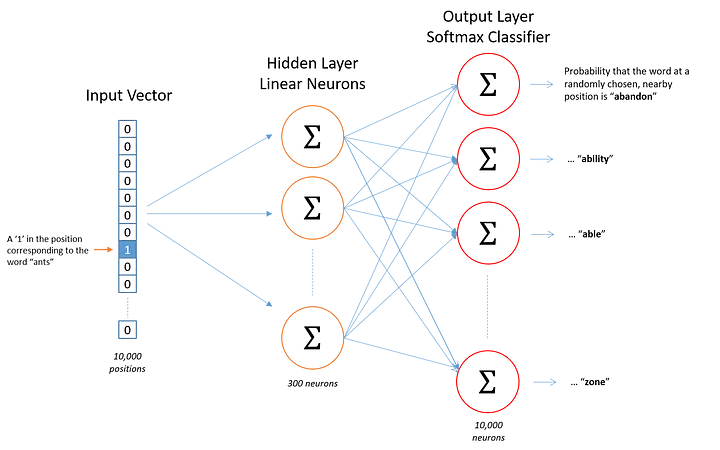

In [ ]:
target_words = np.array([pair[0] for pair in pairs])
context_words = np.array([pair[1] for pair in pairs])
labels = np.array(labels)

# Print sample data
print("Target words shape:", target_words[:3])
print("Context words shape:", context_words[:3])
print("Labels shape:", labels[:3])

Target words shape: [  1 595   1]
Context words shape: [412   1  92]
Labels shape: [0 1 1]


The batch_size parameter in machine learning, particularly in training neural networks, determines how many examples (data points) are processed together in one iteration (one forward and backward pass) of the model during training.

In [ ]:
epochs = 100
batch_size = 128

history = model.fit(x=target_words, y=labels, epochs=epochs, batch_size=batch_size, verbose=1)

This fetches the learned word vectors (embeddings) from the first layer of the model.

In [ ]:
word_vectors = model.layers[0].get_weights()[0]

## Testing the model

In [ ]:
# Example: Print vector for a specific word
word = "sun"
word_index_sun = word_index[word]
word_vector_sun = word_vectors[word_index_sun]
print(f"Vector for word '{word}':", word_vector_sun)

Vector for word 'sun': [-0.04995691 -0.02354397 -0.01535579 -0.00777103 -0.0111794  -0.00087384
 -0.01656079 -0.00046383 -0.00842159 -0.00522517 -0.00295057 -0.01307272
 -0.01981339 -0.0087378  -0.00304357 -0.01542761 -0.00352961 -0.01462828
 -0.01836645 -0.00308486 -0.00947519 -0.00923781 -0.00636598 -0.00949104
 -0.01085035 -0.00986866 -0.00712285 -0.00183876 -0.01471762 -0.03251972
 -0.01214327 -0.00246868 -0.01132192 -0.00084095 -0.00257912 -0.01953303
 -0.02521357 -0.0019329  -0.01869153 -0.01643161 -0.00839895 -0.01062655
 -0.02596357 -0.01111285 -0.01050285 -0.01688613 -0.01991721 -0.01051365
 -0.00165636 -0.00784271]


## Saving the model

In [ ]:
model.save('word2vec_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Loading the saved model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/NLP/

/content/drive/My Drive/NLP


In [ ]:
from keras.models import load_model
model = load_model('word2vec_model.h5')

In [ ]:
word_vectors = model.layers[0].get_weights()[0]

In [ ]:
word = "sun"

# This will give the unique integer assigned to sun
word_index_sun = word_index[word] # getting the index of the word
word_vector_sun = word_vectors[word_index_sun]
print(f"Vector for word '{word}':", word_vector_sun)

Vector for word 'sun': [-0.04995691 -0.02354397 -0.01535579 -0.00777103 -0.0111794  -0.00087384
 -0.01656079 -0.00046383 -0.00842159 -0.00522517 -0.00295057 -0.01307272
 -0.01981339 -0.0087378  -0.00304357 -0.01542761 -0.00352961 -0.01462828
 -0.01836645 -0.00308486 -0.00947519 -0.00923781 -0.00636598 -0.00949104
 -0.01085035 -0.00986866 -0.00712285 -0.00183876 -0.01471762 -0.03251972
 -0.01214327 -0.00246868 -0.01132192 -0.00084095 -0.00257912 -0.01953303
 -0.02521357 -0.0019329  -0.01869153 -0.01643161 -0.00839895 -0.01062655
 -0.02596357 -0.01111285 -0.01050285 -0.01688613 -0.01991721 -0.01051365
 -0.00165636 -0.00784271]


Saving the vectors into a file

In [ ]:
# Save embeddings for vectors of length 50, 150 and 300 using skipgram model
weights = model.get_weights()

# Get the embedding matrix
embedding = weights[0]

# Get word embeddings for each word in the vocabulary, write to file
f = open(f"vectors_skipgram_{len(embedding[0])}.txt", "w")

# Create columns for the words and the values in the matrix, makes it easier to read as dataframe
columns = ["word"] + [f"value_{i+1}" for i in range(embedding.shape[1])]

# Start writing to the file, start with the column names
f.write(" ".join(columns))

# Start a new line
f.write("\n")

for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(embedding[i,:]))))
    f.write("\n")
f.close()

## Reading from file

In [11]:
def readingembedding(filepath):
  embedding={}

  with open(filepath,'r') as f:
    # Skip the first line (header)
    next(f)

    # line.strip().split() will split the string into a list of substrings, using whitespace as the delimiter, resulting in ["the", "0.1", "0.2", "0.3", "0.4", "0.5"]
    for i in f:
      values = i.strip().split()
      word=values[0]
      vector = np.array(values[1:], dtype='float32')
      embedding[word] = vector

  return embedding




In [12]:
file_path = "vectors_skipgram_50.txt"  # Change this to the appropriate file name
embeddings = readingembedding(file_path)

In [15]:
import random

sample_size=3
random_samples=random.sample(list(embeddings.items()), sample_size)

dictrandom_samples=dict(random_samples)
print(dictrandom_samples)

{'buttered': array([-0.00297961, -0.01606287, -0.016033  , -0.04033352, -0.03449333,
       -0.01051829, -0.00125878, -0.02459539, -0.00701919, -0.04350924,
       -0.04383783, -0.01495953, -0.00677735, -0.00136663, -0.01395463,
       -0.01989064, -0.02675771, -0.00988851, -0.01561086, -0.00980498,
       -0.04159708, -0.01578193, -0.00477438, -0.00235357, -0.01867942,
       -0.0241338 , -0.03335074, -0.00748007, -0.00767965, -0.01753655,
       -0.0026471 , -0.00516949, -0.00978832, -0.04524856, -0.04051555,
       -0.00623385, -0.01196444, -0.01452777, -0.02158355, -0.02369903,
       -0.04832441, -0.02348122, -0.01539618, -0.01181166, -0.00733155,
       -0.00752114, -0.00190257, -0.01504108, -0.01965774, -0.01267564],
      dtype=float32), 'eats': array([-1.17206248e-02, -3.75913270e-02, -4.93128598e-03, -1.12114707e-02,
       -1.07162809e-02, -3.64086851e-02, -4.86602075e-03, -1.75129939e-02,
       -1.44081993e-03, -2.31393101e-03, -7.91653525e-03, -9.87029076e-03,
       -1.2

## First read the vectors from file and then implement this to get the context words from a target word

## Similarity = (A.B) / (||A||.||B||)

In [ ]:
import numpy as np
from numpy.linalg import norm

def find_context_word(target_word_vector, word_to_vec, top_n=5):
  similarities={}

  for word, vector in word_to_vec.items():
    # Compute cosine similarity between target_word_vector and each word's vector
    cosinesimil=np.dot(target_word_vector, vector)/ (norm(target_word_vector)*norm(vector))
    similarities[word]=cosinesimil

    # Sort words by similarity in descending order on the basis of score
    sorted_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

  return sorted_words[:top_n]

In [ ]:
word = "king"
word_index_sun = word_index[word] # getting the index of the word
word_vector_sun = word_vectors[word_index_sun]
print(f"Vector for word '{word}':", word_vector_sun)

top_context_words=find_context_word(word_vector_sun,embeddings)

print(f"Context words for '{word}':")
for word, similarity in top_context_words:
    print(f"{word}: Similarity {similarity:.4f}")

Vector for word 'king': [-0.04029531 -0.01251701 -0.00844074 -0.03478764 -0.00648273 -0.00528194
 -0.02896863 -0.00697941 -0.00729364 -0.00522171 -0.00698193 -0.04181821
 -0.01228357 -0.02159925 -0.00928047 -0.03116969 -0.00384338 -0.00414772
 -0.00912029 -0.00301068 -0.00255873 -0.01239972 -0.04025835 -0.02359065
 -0.0234599  -0.04459349 -0.01736427 -0.01176924 -0.00519021 -0.03658069
 -0.01083696 -0.00880999 -0.03069806 -0.00918678 -0.01068323 -0.0075828
 -0.00688941 -0.00278039 -0.03815588 -0.00991805 -0.00540503 -0.02679384
 -0.00744081 -0.03888807 -0.04089154 -0.0353977  -0.04921369 -0.04165797
 -0.04488122 -0.04326341]
Context words for 'king':
king: Similarity 1.0000
puppy: Similarity 0.8001
the: Similarity 0.7928
fumbled: Similarity 0.7902
tales: Similarity 0.7888


# Implementing Word2vec with CBOW

1.   Data pre processing is done above



## Generate CBOW Training Data
The CBOW contains the context of a word and the target word itself but in the form of integers

In [16]:
# Window size 2 means that 2 words before the target word and 2 words after the target words
window_size=2
context_target_pairs = []

# sequences if given above ([1,2,3,4],[3,4,5,6])
for sequence in sequences:
  for i, target_word in enumerate(sequence):
    context=[]

    # The context would be from min index 0 or target word - windows size to min length of sequence and the target word +window
    for j in range(max(0,i-window_size), min(len(sequence), i+window_size+1)):
      # this would exclude the word itself from the context
      if j!=i:
        context.append(sequence[j])

    # to avoid the keyvalue error of numpy which happens when the context lenght are not same then we add zeros as many times to get equal length for all context list
    if len(context) < 2 * window_size:
      context = context + [0] * (2 * window_size - len(context))
    context_target_pairs.append((context, target_word))


In [17]:
context_target_pairs[0:3]

[([7, 38, 0, 0], 305), ([305, 38, 1, 0], 7), ([305, 7, 1, 92], 38)]

## Separating the input and ouput data which is context and target word

Y=to_categorical(np.array(y), num_classes=vocab_size)
This converts Y into an np array

y = np.array([1, 2, 34, 4, 5, 6, 7, 8, 5, 3, 2, 4, 5, 5])

and then one hot vector

array([
 [1., 0., 0., 0., 0.],  # 0 -> [1, 0, 0, 0, 0]
 [0., 1., 0., 0., 0.],  # 1 -> [0, 1, 0, 0, 0]
 [0., 0., 1., 0., 0.],  # 2 -> [0, 0, 1, 0, 0]
 [0., 0., 0., 1., 0.],  # 3 -> [0, 0, 0, 1, 0]
 [0., 0., 0., 0., 1.]   # 4 -> [0, 0, 0, 0, 1]
])


In [ ]:
X=[]
Y=[]

for context, target in context_target_pairs:
  X.append(context)
  Y.append(target)

X=np.array(X)
Y=to_categorical(np.array(Y), num_classes=vocab_size)

In [ ]:
print(X[:4])
print(Y[:4])

[[  7  38   0   0]
 [305  38   1   0]
 [305   7   1  92]
 [  7  38  92 595]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


## Creating the architecture

Input Layer:

Shape: The input layer takes a fixed-size context window as input. For example, if the window size is 2, the context size would be 2 * window_size (e.g., 4).
Data: The input is a list of word indices representing the context words.

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Lambda, Dense

context_size = 2 * window_size  # The total number of context words
embedding_dim = 100  # The size of the embedding vectors
input_layer = Input(shape=(context_size,))  # Input layer

Embedding Layer:

Purpose: The embedding layer converts the input word indices into dense vectors of fixed size (embedding dimension).

Parameters:
input_dim: The size of the vocabulary (total number of unique words).

output_dim: The size of the embedding vectors (e.g., 100).

input_length: The length of the input sequence (context size).

Output: A 2D tensor where each word index is replaced by its corresponding dense vector.

In [ ]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=context_size)(input_layer)  # Embedding layer

Averaging Layer:

Averages the embeddings of the context words along the axis corresponding to the context words (axis=1). The resulting shape of the output tensor is (batch_size, embedding_dim).

The averaging layer takes this matrix of context word embeddings and computes the mean of these embeddings.

This operation reduces the dimensionality of the tensor by averaging the vectors along the axis corresponding to the context words.

The purpose of averaging is to produce a single vector that summarizes the information from all context words.

The resulting vector has the same dimensionality as the embedding vectors, but it now represents the average context.

In [ ]:
averaging_layer = Lambda(lambda x: tf.reduce_mean(x, axis=1))(embedding_layer)  # Averaging layer

Dense (Output) Layer:

Purpose: The dense layer predicts the target word based on the averaged context vector.

Activation Function: Typically, a softmax activation function is used to output a probability distribution over the vocabulary.

Output: A vector of probabilities, one for each word in the vocabulary.

In [ ]:
output_layer = Dense(vocab_size, activation='softmax')(averaging_layer)  # Output layer

Compilation and Training:

The model is compiled with the categorical cross-entropy loss function and the Adam optimizer.
The model is trained on the prepared input (context words) and output (target word) data.

In [ ]:
from tensorflow.keras.models import Model

# Create and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer=Adam())

In [ ]:
# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 embedding (Embedding)       (None, 4, 100)            255700    
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense (Dense)               (None, 2557)              258257    
                                                                 
Total params: 513957 (1.96 MB)
Trainable params: 513957 (1.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(X, Y, epochs=10, batch_size=32)

Epoch 1/10
849/849 [==============================] - 10s 10ms/step - loss: 6.4833
Epoch 2/10
849/849 [==============================] - 10s 12ms/step - loss: 5.8823
Epoch 3/10
849/849 [==============================] - 10s 12ms/step - loss: 5.6342
Epoch 4/10
849/849 [==============================] - 8s 10ms/step - loss: 5.3968
Epoch 5/10
849/849 [==============================] - 10s 12ms/step - loss: 5.1696
Epoch 6/10
849/849 [==============================] - 9s 11ms/step - loss: 4.9526
Epoch 7/10
849/849 [==============================] - 11s 13ms/step - loss: 4.7527
Epoch 8/10
849/849 [==============================] - 10s 12ms/step - loss: 4.5687
Epoch 9/10
849/849 [==============================] - 8s 10ms/step - loss: 4.3979
Epoch 10/10
849/849 [==============================] - 14s 16ms/step - loss: 4.2370


# Testing Phase

The model basically just recieves the indexes of the context words from the word_index which has assigned int to each word in the corpus

In [ ]:
embeddingsCBOW = model.get_weights()[0]

In [ ]:
import numpy as np

target_word = "king"
context_words = ["the", "queen"]

# getting the index of target word
target_word_index = word_index[target_word]

# getting the index of context words
context_word_indices = []
for word in context_words:
    context_word_indices.append(word_index[word])

# As the context size should be same so it will fill the remaining space with zeroes
context_word_indices= np.array(context_word_indices)
context_vector = np.zeros(shape=(1, context_size))
for i, index in enumerate(context_word_indices):
    context_vector[0, i] = index


context_vector=np.array(context_vector)

# Dimensions: The array will have a shape of (1, vocab_size), which means it will have 1 row and vocab_size columns.
y_test = np.zeros((1, vocab_size))

# making the index of the target word as 1
y_test[0, word_index[target_word]] = 1

predictions = model.predict(context_vector)

# Evaluate the prediction
predicted_class = np.argmax(predictions, axis=1)
true_class = np.argmax(y_test, axis=1)

print(f"Predicted class: {predicted_class}")
print(f"True class: {true_class}")

1/1 [==============================] - 0s 32ms/step
Predicted class: [9]
True class: [73]


In [ ]:
accuracy = np.mean(predicted_class == true_class)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.0000
